In [8]:
%load_ext autoreload
%autoreload 2

import cv2 as cv
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

from qdanalysis.preprocessing.strokedecomposition import simple_stroke_segment
import pathlib

In [2]:
#to make generated figures easier to view
mpl.rcParams['figure.dpi']=300

In [3]:
path = pathlib.Path('./CERUG')
files = [fp for fp in path.iterdir()]

In [4]:
pathname = str(files[2])
parts = pathname.split('\\')
print("parts of filepath: ", parts)
filename = parts[-1]
print("filename: ", filename)

re.search(r'(\d*)_(\d*)(-\d*)?', filename)[3] == None

parts of filepath:  ['CERUG/Writer0202_01.ppm']
filename:  CERUG/Writer0202_01.ppm


True

In [23]:
image = cv.imread('./CERUG/Writer0909_03-01.ppm', cv.IMREAD_GRAYSCALE)
image.dtype

dtype('uint8')

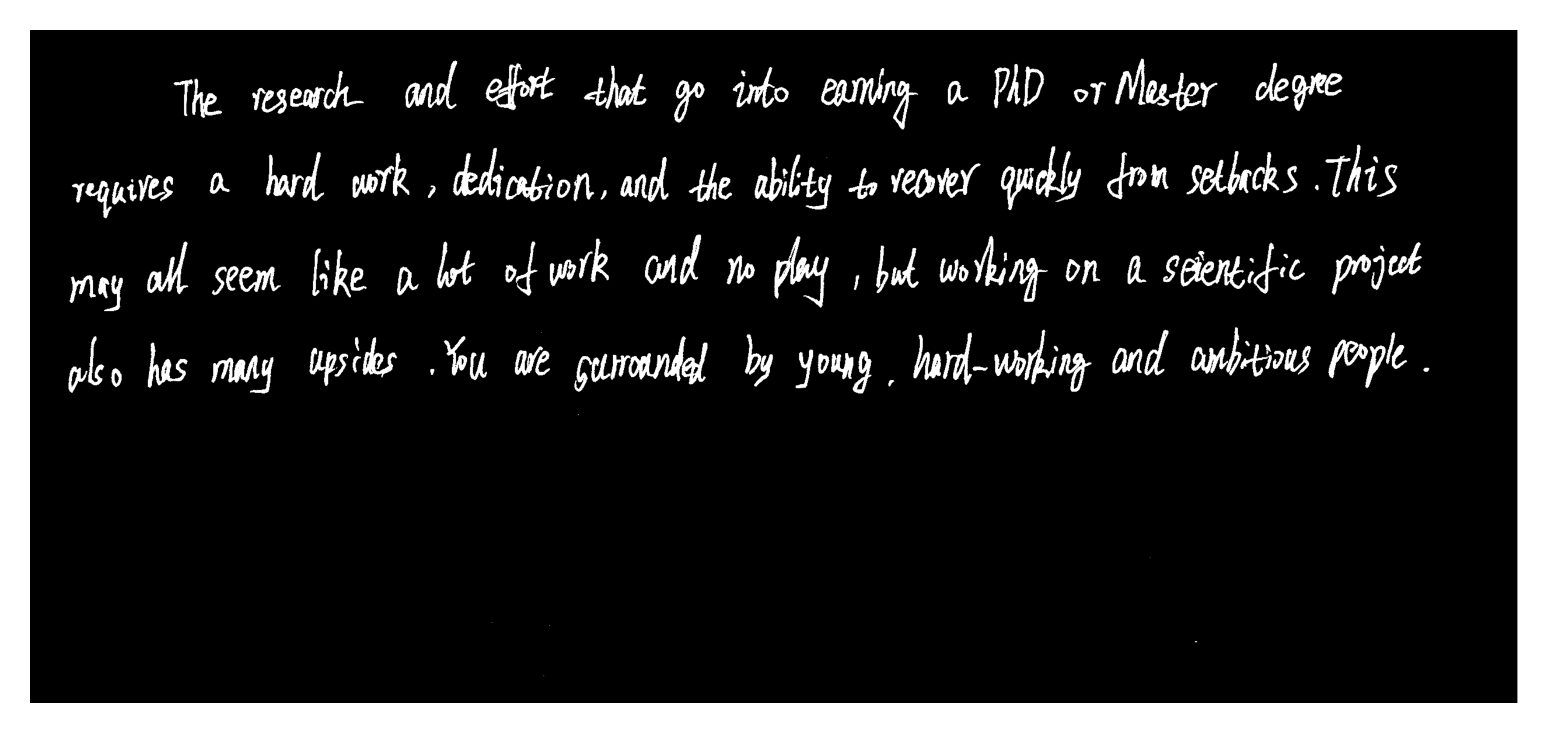

In [24]:
image_bin = cv.threshold(image, 0, 1, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
plt.imshow(image_bin, cmap='gray')
plt.axis('off')
plt.show()

In [25]:
strokes = simple_stroke_segment(image)
len(strokes)

1159


1159

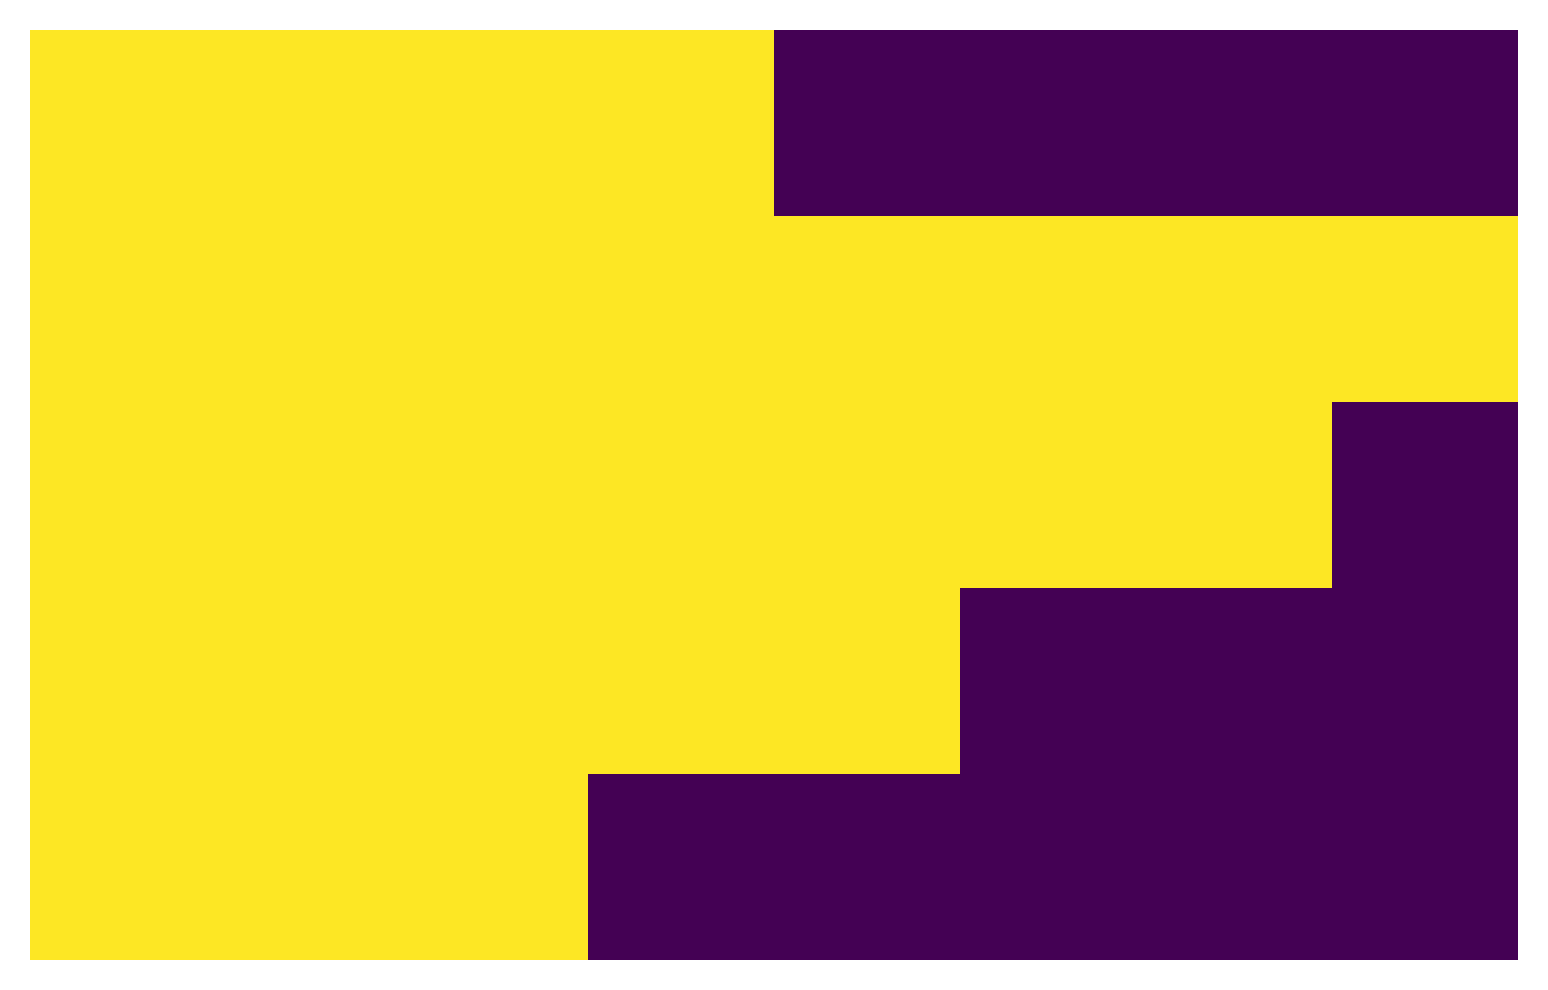

In [30]:
plt.imshow(strokes[500])
plt.axis('off')
plt.show()

In [ ]:
for fp in path.iterdir():
    fp.

SyntaxError: invalid syntax (3683060060.py, line 2)